In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import random
import rasterio
import numpy as np
import classic_algos.bicubic_interpolation as bicubic
import classic_algos.lanczos as lanczos
from skimage.color import rgb2ycbcr

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from pathlib import Path

# Настройки воспроизводимости и ускорения как в статье
import torch.backends.cudnn as cudnn

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))


BATCH_SIZE = 16
EPOCHS = 2000

TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


class SatelliteSRDataset_Y(Dataset):
    def __init__(self, root_dir, scale_factor=2, hr_patch_size=20, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.augment = augment
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()

        image_hwc = np.transpose(image, (1, 2, 0)).astype(np.uint8)

        image_y = rgb2ycbcr(image_hwc)[:, :, 0]

        image_norm = image_y.astype(np.float32) / 255.0

        image_norm = image_norm[np.newaxis, :, :]

        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top + self.hr_patch_size, left:left + self.hr_patch_size]

        if self.augment:
            if random.random() < 0.5: hr_patch_np = np.flip(hr_patch_np, axis=2)
            if random.random() < 0.5: hr_patch_np = np.flip(hr_patch_np, axis=1)
            k = random.choice([0, 1, 2, 3])
            if k > 0: hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np)
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))
        lr_size = self.hr_patch_size // self.scale_factor
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)

        if lr_numpy_hwc.ndim == 2:
            lr_numpy_hwc = lr_numpy_hwc[:, :, np.newaxis]

        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = self.conv2(self.relu(self.conv1(x)))
        return x + residual  # Skip connection: добавляем вход к выходу


class ResSRCNN_Y(nn.Module):
    def __init__(self, scale_factor=2, num_channels=1, num_res_blocks=8, n_feats=64):
        super(ResSRCNN_Y, self).__init__()

        # 1. Head: Первый слой извлекает фичи
        self.head = nn.Conv2d(num_channels, n_feats, kernel_size=3, padding=1)

        # 2. Body: Последовательность Residual блоков
        # Чем больше блоков, тем выше качество (обычно 8, 16 или 32)
        self.body = nn.Sequential(*[
            ResidualBlock(n_feats) for _ in range(num_res_blocks)
        ])

        # Дополнительная свертка после блоков + глобальный skip connection (в forward)
        self.body_end = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

        # 3. Upsampling: PixelShuffle вместо Deconv
        # Для scale=2 нужен один блок, для scale=4 — два блока по x2
        if scale_factor == 2:
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.ReLU(inplace=True)
            )
        elif scale_factor == 3:
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 9, kernel_size=3, padding=1),
                nn.PixelShuffle(3),
                nn.ReLU(inplace=True)
            )
        elif scale_factor == 4:  # Делаем 2 раза по x2
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.ReLU(inplace=True),
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.ReLU(inplace=True)
            )

        # 4. Tail: Сжимаем обратно к 1 каналу (или 3)
        self.tail = nn.Conv2d(n_feats, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        res = self.body_end(res)
        res += x  # Global Residual Connection: пробрасываем фичи через всю сеть

        x = self.upsample(res)
        x = self.tail(x)

        return torch.clamp(x, 0.0, 1.0)


y_train_dataset = SatelliteSRDataset_Y(TRAIN_DIR, scale_factor=2, hr_patch_size=144, augment=True)
y_val_dataset = SatelliteSRDataset_Y(VAL_DIR, scale_factor=2, hr_patch_size=144, augment=False)
y_train_loader = DataLoader(y_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
y_val_loader = DataLoader(y_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

y_model = ResSRCNN_Y(scale_factor=2).to(device)
y_criterion = nn.L1Loss()
# Оптимизатор SGD с momentum и weight_decay как в статье
y_optimizer = optim.Adam(y_model.parameters(), lr=1e-4, betas=(0.9, 0.999))

y_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(y_optimizer, mode='min', factor=0.5, patience=10)

y_loss = []
y_psnr_metric = []
best_psnr = 0

In [ ]:
for epoch in range(EPOCHS):
    y_model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(y_train_loader, desc=f"Epoch {epoch} (Y)"):
        lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
        y_optimizer.zero_grad()
        sr_imgs = y_model(lr_imgs)
        batch_loss = y_criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        y_optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(y_train_loader)
    y_loss.append(avg_loss)
    # === VALIDATION (Каждую эпоху!) ===
    y_model.eval()
    val_loss = 0
    val_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in y_val_loader:  # убираем tqdm тут, чтобы не засорять лог
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = y_model(lr_imgs)

            # Считаем и Loss, и PSNR
            loss = y_criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()
            val_psnr += PSNR(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(y_val_loader)
    avg_val_psnr = val_psnr / len(y_val_loader)

    print(f"Epoch {epoch}: Train Loss: {avg_loss:.5f} | Val Loss: {avg_val_loss:.5f} | Val PSNR: {avg_val_psnr:.2f} dB")

    # === SCHEDULER STEP ===
    # Скармливаем ему Валидационный Лосс
    y_scheduler.step(avg_val_loss)

    # Сохраняем лучшую модель
    if avg_val_psnr > best_psnr:
        best_psnr = avg_val_psnr
        torch.save(y_model.state_dict(), MODEL_DIR / 'best_model.pth')
        print(f"  [!] New Best PSNR: {best_psnr:.2f} dB saved.")

    # Можно сохранять чекпоинт раз в N эпох на всякий случай
    if epoch % 20 == 0:
        torch.save(y_model.state_dict(), MODEL_DIR / f'checkpoint_{epoch}.pth')

print("Y-channel training complete.")

Epoch 0 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 0: Train Loss: 0.07111 | Val Loss: 0.02825 | Val PSNR: 26.05 dB
  [!] New Best PSNR: 26.05 dB saved.


Epoch 1 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 1: Train Loss: 0.02395 | Val Loss: 0.02325 | Val PSNR: 28.14 dB
  [!] New Best PSNR: 28.14 dB saved.


Epoch 2 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 2: Train Loss: 0.02019 | Val Loss: 0.01985 | Val PSNR: 28.68 dB
  [!] New Best PSNR: 28.68 dB saved.


Epoch 3 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

/home/aaa/.data/fsrcnn_models/checkpoint_260.pth


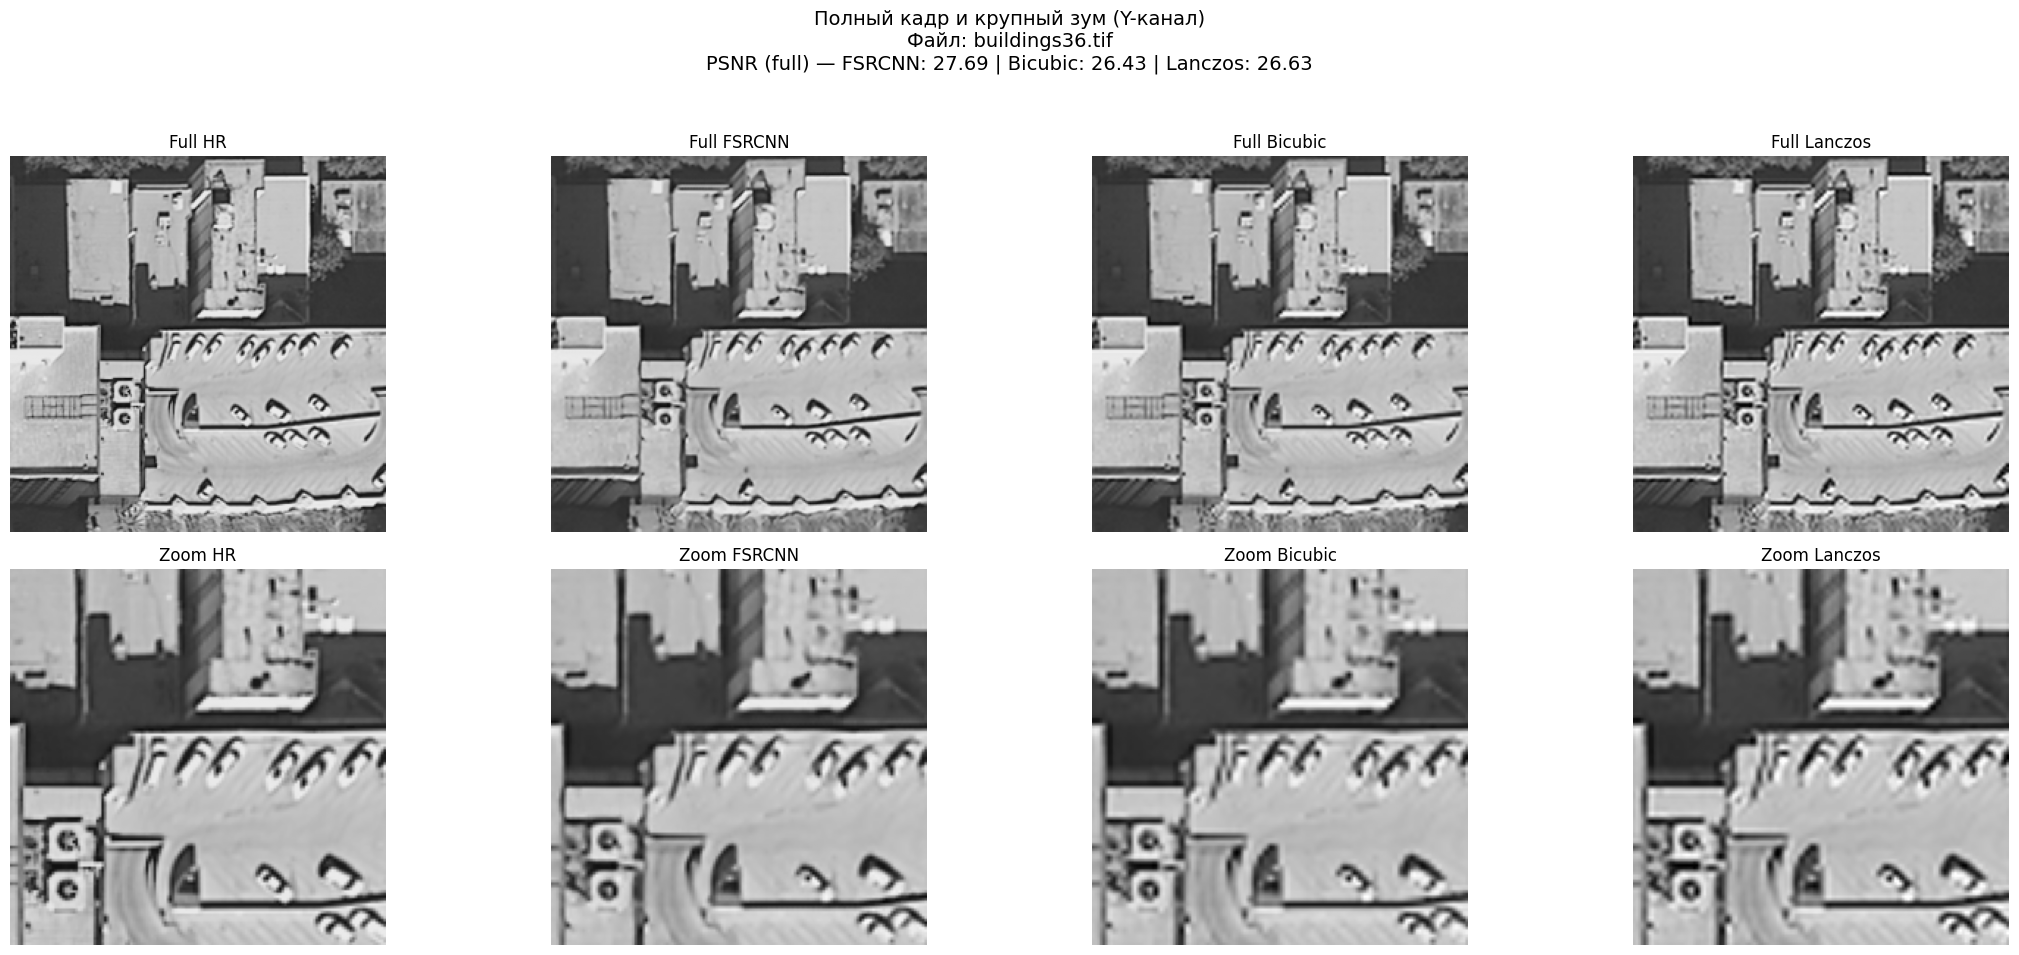

Full-image PSNR — FSRCNN: 27.69 dB | Bicubic: 26.43 dB | Lanczos: 26.63 dB
Zoom region: top=56, left=56, size=144x144


In [9]:
# Настройки визуализации
ZOOM_PATCH_SIZE = 144  # размер квадрата для зума на HR масштабе
ZOOM_TOP_LEFT = None   # (top, left) если None, выберется центр кадра
SCALE_Y = 2            # масштаб для Y-модели

# 1) Выбор исходного файла из валид. набора и загрузка полного изображения
full_idx = random.randint(0, len(y_val_dataset.file_paths) - 1)
img_path = y_val_dataset.file_paths[full_idx]
with rasterio.open(img_path) as src:
    image = src.read()  # C x H x W, ожидаем RGB

# Перевод в HWC и Y-канал
image_hwc = np.transpose(image, (1, 2, 0)).astype(np.uint8)
image_y = rgb2ycbcr(image_hwc)[:, :, 0].astype(np.float32) / 255.0  # [0,1]

# Приведение к кратности масштаба (обрезка, чтобы H,W делились на SCALE_Y)
H, W = image_y.shape
H_adj = H - (H % SCALE_Y)
W_adj = W - (W % SCALE_Y)
image_y = image_y[:H_adj, :W_adj]

# Формирование LR через бикубик, затем получение SR
lr_h = H_adj // SCALE_Y
lr_w = W_adj // SCALE_Y

# bicubic downscale до LR
lr_y_hwc = bicubic.SR_bicubic(image_y[:, :, np.newaxis], lr_h, lr_w,
                              preserve_range=True, output_dtype=np.float32)
# защита на случай 2D
if lr_y_hwc.ndim == 2:
    lr_y_hwc = lr_y_hwc[:, :, np.newaxis]

# CHW тензор для модели
lr_y_chw = np.transpose(lr_y_hwc, (2, 0, 1))  # (1, lr_h, lr_w)
lr_tensor_full = torch.from_numpy(lr_y_chw).unsqueeze(0).to(device)  # (1,1,lr_h,lr_w)

# 2) Инференс FSRCNN-Y
model_y_compare = ResSRCNN_Y(scale_factor=SCALE_Y).to(device)
# Если есть последняя сохраненная, попробуем ее загрузить; иначе оставим случайные веса
latest_ckpt = None
try:
    ckpts = sorted([p for p in MODEL_DIR.glob('ResSRCNN_Y_epoch_*.pth')], key=lambda x: x.stat().st_mtime, reverse=True)
    if ckpts:
        latest_ckpt = ckpts[0]
        #latest_ckpt = '/home/aaa/.data/fsrcnn_models/ResSRCNN_Y_epoch_paper_mae_1700.pth'
        latest_ckpt = '/home/aaa/.data/fsrcnn_models/checkpoint_260.pth'
        print(latest_ckpt)
        model_y_compare.load_state_dict(torch.load(latest_ckpt, map_location=device))
        model_y_compare.eval()
except Exception:
    print(Exception)
    model_y_compare.eval()

with torch.no_grad():
    sr_fsrcnn_full = model_y_compare(lr_tensor_full)  # (1,1,H_adj,W_adj)

# 3) Бикубик и Ланцош до HR размера
sr_bicubic_full_hwc = bicubic.SR_bicubic(lr_y_hwc, H_adj, W_adj,
                                         preserve_range=True, output_dtype=np.float32)
if sr_bicubic_full_hwc.ndim == 2:
    sr_bicubic_full_hwc = sr_bicubic_full_hwc[:, :, np.newaxis]
sr_bicubic_full_chw = np.transpose(sr_bicubic_full_hwc, (2, 0, 1))
sr_bicubic_full = torch.from_numpy(sr_bicubic_full_chw).unsqueeze(0).to(device)

sr_lanczos_full_hwc = lanczos.resize_lanczos_vectorized(lr_y_hwc, H_adj, W_adj,
                                                        output_dtype=np.float32, preserve_range=True)
if sr_lanczos_full_hwc.ndim == 2:
    sr_lanczos_full_hwc = sr_lanczos_full_hwc[:, :, np.newaxis]
sr_lanczos_full_chw = np.transpose(sr_lanczos_full_hwc, (2, 0, 1))
sr_lanczos_full = torch.from_numpy(sr_lanczos_full_chw).unsqueeze(0).to(device)

# GT HR как тензор
hr_full = torch.from_numpy(image_y[np.newaxis, np.newaxis, :, :].astype(np.float32)).to(device)

# 4) PSNR на полном кадре
psnr_fsrcnn_full = PSNR(sr_fsrcnn_full, hr_full).item()
psnr_bicubic_full = PSNR(sr_bicubic_full, hr_full).item()
psnr_lanczos_full = PSNR(sr_lanczos_full, hr_full).item()

# 5) Подготовка зум-области
if ZOOM_TOP_LEFT is None:
    top = max((H_adj - ZOOM_PATCH_SIZE) // 2, 0)
    left = max((W_adj - ZOOM_PATCH_SIZE) // 2, 0)
else:
    # Безопасная распаковка: ожидаем (top, left)
    if isinstance(ZOOM_TOP_LEFT, (tuple, list)) and len(ZOOM_TOP_LEFT) == 2:
        top, left = int(ZOOM_TOP_LEFT[0]), int(ZOOM_TOP_LEFT[1])
    else:
        # Если формат неверный — используем центр
        top = max((H_adj - ZOOM_PATCH_SIZE) // 2, 0)
        left = max((W_adj - ZOOM_PATCH_SIZE) // 2, 0)
    top = min(max(0, top), H_adj - ZOOM_PATCH_SIZE)
    left = min(max(0, left), W_adj - ZOOM_PATCH_SIZE)

def crop(tensor_b1c1hw):
    # tensor shape: (1,1,H,W)
    return tensor_b1c1hw[:, :, top:top+ZOOM_PATCH_SIZE, left:left+ZOOM_PATCH_SIZE]

hr_zoom = crop(hr_full)
sr_fsrcnn_zoom = crop(sr_fsrcnn_full)
sr_bicubic_zoom = crop(sr_bicubic_full)
sr_lanczos_zoom = crop(sr_lanczos_full)

# 6) Визуализация: полноразмерный + зум
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle(f'Полный кадр и крупный зум (Y-канал)\nФайл: {Path(img_path).name}\nPSNR (full) — FSRCNN: {psnr_fsrcnn_full:.2f} | Bicubic: {psnr_bicubic_full:.2f} | Lanczos: {psnr_lanczos_full:.2f}', fontsize=14)

labels = ['HR', 'FSRCNN', 'Bicubic', 'Lanczos']
rows = [(hr_full, 'Full HR'), (sr_fsrcnn_full, 'Full FSRCNN'), (sr_bicubic_full, 'Full Bicubic'), (sr_lanczos_full, 'Full Lanczos')]
for j, (tensor, title) in enumerate(rows):
    img = tensor.squeeze().detach().cpu().numpy()
    axes[0, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, j].axis('off')
    axes[0, j].set_title(title)

rows_zoom = [(hr_zoom, 'Zoom HR'), (sr_fsrcnn_zoom, f'Zoom FSRCNN'), (sr_bicubic_zoom, 'Zoom Bicubic'), (sr_lanczos_zoom, 'Zoom Lanczos')]
for j, (tensor, title) in enumerate(rows_zoom):
    img = tensor.squeeze().detach().cpu().numpy()
    axes[1, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, j].axis('off')
    axes[1, j].set_title(title)

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

print(f"Full-image PSNR — FSRCNN: {psnr_fsrcnn_full:.2f} dB | Bicubic: {psnr_bicubic_full:.2f} dB | Lanczos: {psnr_lanczos_full:.2f} dB")
print(f"Zoom region: top={top}, left={left}, size={ZOOM_PATCH_SIZE}x{ZOOM_PATCH_SIZE}")
